# Coarse Variable Alignment: The Repetitive Case
We compare two approaches: (a) local neighbor rotation angles and then solve a global problem for global angles that are consistent with the periodicity; (b) find *one repetitive* rotation angle and do it *locally*.

In [29]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import helmholtz.repetitive.coarsening_repetitive as hrc
import helmholtz.analysis
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize
import sklearn.metrics.pairwise

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format

logger = logging.getLogger("main")
_LOGGER = logger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
def get_test_matrix(a, n, num_sweeps, num_examples: int = None):
    level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
    x = hm.solve.run.random_test_matrix((n,), num_examples=num_examples)
    b = np.zeros_like(x)
    x, _ = hm.solve.run.run_iterative_method(level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
    return x

def rotation(t):
    c, s = np.cos(t), np.sin(t)
    return np.array([[c, s], [-s, c]])

def get_local_rotation_min_function(X, Y, t, scale=False, p=2):
    if scale:
        scale_x = (0.5 * (norm(X[:, 0]) + norm(X[:, 1]))) ** 0.5
        scale0 = norm(Y[:, 0]) ** 2 * scale_x
        scale1 = norm(Y[:, 1]) ** 2 * scale_x
    else:
        scale0 = scale1 = 1
    return \
        norm( np.cos(t) * X[0] + np.sin(t) * X[1] - Y[0]) ** p / scale0 + \
        norm(-np.sin(t) * X[0] + np.cos(t) * X[1] - Y[1]) ** p / scale1

def get_local_rotation_angle(X, Y):
    return optimize.minimize_scalar(lambda t: get_local_rotation_min_function(X, Y, t),
                                    bounds=(-np.pi, np.pi), method='brent').x

## Problem Parameters

In [31]:
# Fixed seed for reproducible results.
np.random.seed(1)

# Problem + domain.
kh = 0.5
repetitive = True
n = 96

# Test vectors.
num_examples = 6
num_sweeps = 10

# Coarsening.
aggregate_size = 4
num_components = 2

# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, "5-point", n) #, bc="bloch")
# Use default Kacmzarz for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

## Generate Test Vectors

### Ideal Vectors

In [32]:
x_ideal, lam = hm.analysis.ideal.ideal_tv(a, num_examples)
print("eigenvalues", lam)

eigenvalues [-0.024 -0.024  0.04   0.04   0.096  0.096 -0.097 -0.097  0.143  0.143 -0.178 -0.178  0.181  0.181  0.211  0.211  0.233  0.233  0.246  0.246  0.25  -0.267 -0.267 -0.364 -0.364 -0.47  -0.47  -0.583 -0.583 -0.705 -0.705 -0.833 -0.833 -0.969 -0.969 -1.112 -1.112 -1.261 -1.261 -1.415 -1.415 -1.576 -1.576 -1.741 -1.741 -1.91  -1.91  -2.083 -2.083 -2.259 -2.259 -2.437 -2.437 -2.616 -2.616 -2.796 -2.796 -2.975 -2.975 -3.153 -3.153 -3.328 -3.328 -3.5   -3.5   -3.668 -3.668 -3.83  -3.83  -3.987 -3.987
 -4.136 -4.136 -4.277 -4.277 -4.409 -4.409 -4.531 -4.531 -4.643 -4.643 -4.743 -4.743 -4.832 -4.832 -4.907 -4.907 -4.97  -4.97  -5.019 -5.019 -5.055 -5.055 -5.076 -5.076 -5.083]


### Use Relaxed Vectors

In [33]:
# Create relaxed test vectors.
x_relaxed = get_test_matrix(a, n, num_sweeps, num_examples=num_examples)

## Create a Coarsening Matrix $R$

In [34]:
def create_coarsening(x):
    # Construct coarsening on an aggregate.
    x_aggregate_t = np.concatenate(
        tuple(hm.linalg.get_window(x, offset, aggregate_size)
              for offset in range(max((4 * aggregate_size) // x.shape[1], 1))), axis=1).transpose()

    # Tile the same coarsening over all aggregates.
    r, s = hm.setup.coarsening_uniform.create_coarsening(x_aggregate_t, num_components)
    r = hrc.Coarsener(r)
    R = r.tile(n // aggregate_size)
    xc = R.dot(x)

    display(pd.DataFrame(R[:5,:10].todense()))

    fig, axs = plt.subplots(1, 3, figsize=(14, 4))

    ax = axs[0]
    for i in range(2):
        ax.plot(x[:, i])
    ax.set_title("$x$")
    ax.grid(True);

    ax = axs[1]
    for i in range(2):
        ax.plot(xc[::2, i])
    ax.set_title("$x^c$ Species 0")
    ax.grid(True);


    ax = axs[2]
    for i in range(2):
        ax.plot(xc[1::2, i])
    ax.set_title("$x^c$ Species 1")
    ax.grid(True);
    
    return R, xc

,0,1,2,3,4,5,6,7,8,9
0,0.45,0.56,0.55,0.43,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.66,-0.23,0.25,0.67,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.45,0.56,0.55,0.43,0.00,0.00
3,0.00,0.00,0.00,0.00,-0.66,-0.23,0.25,0.67,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.45,0.56


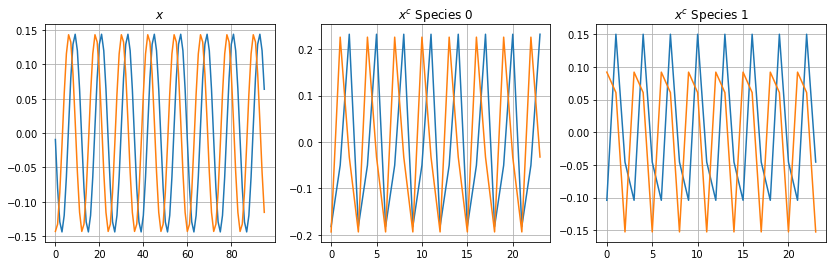

In [35]:
R_ideal, xc_ideal = create_coarsening(x_ideal)

,0,1,2,3,4,5,6,7,8,9
0,0.48,0.62,0.53,0.32,0.00,0.00,0.00,0.00,0.00,0.00
1,0.68,0.13,-0.41,-0.59,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.48,0.62,0.53,0.32,0.00,0.00
3,0.00,0.00,0.00,0.00,0.68,0.13,-0.41,-0.59,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.48,0.62


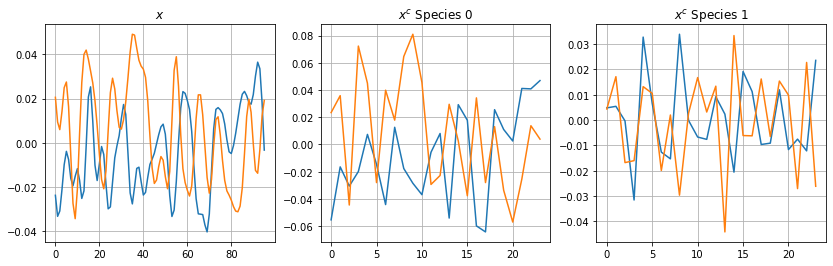

In [36]:
R, xc_relaxed = create_coarsening(x_relaxed)

In [37]:
# # Apply R of relaxed vectors to the ideal vectors instead of constructing the ideal-TV coarsening.
xc_ideal = R.dot(x_ideal)

## Repetitive Rotation Angle Optimization
Sample $s$ windows aggregate pairs $(i,i+1)$ (pairs of consecutive coarse values of different test vectors in different parts of the domain). Let the matrices at $i$ and $i+1$ be $X_{2 \times s}$ and $Y_{2 \times s}$, respectively (recall that "coarse values" here means a pair of two coarse variables per aggregate).

* Step 1: Find the optimal rotation angle $\theta$ that minimizes
$$ \theta = argmin_{\theta} f(\theta) $$
$$ f(\theta) := \frac12 \left\{ \|\cos(\theta) X_0 + \sin(\theta) X_1 - Y_0 \|_2^2 + \|-\sin(\theta) X_0 + \cos(\theta) X_1 - Y_1\|_2^2 \right\}, $$
where $Z_j$ is the $j$th row of $Z$, $Z=X,Y, j=0,1$.

The minimization function $f$ seems to have a unique minimum in $[0, 2 \pi)$.

* Step 2: round $\theta$ to the nearest gridpoint $2 \pi l/n$ value for $l \in Z$ (or the one with the minimum $f$ value of the two grid neighbors of $\theta$). Now the periodicity is satisfied.

In [38]:
def optimal_rotation_angle(xc):
    # Sample concecutive pairs of coarse variables. Because of the ordering of the coarse
    # variables in aggregates over the domain as (0, 1), (2, 3), (4, 5), ..., this means a
    # super-aggregate size = 4. X then corresponds to (0, 1) and Y to (2, 3).
    # Note that window offsets must be even (we don't want to include windows like (1, 2)).
    coarse_aggregate_size = 4

    xc_aggregate_t = np.concatenate(
        tuple(hm.linalg.get_window(xc, offset, coarse_aggregate_size)
              for offset in range(0, max((4 * coarse_aggregate_size) // xc.shape[1], 1), 2)), axis=1).transpose()

    X, Y = xc_aggregate_t[:2], xc_aggregate_t[2:]

    f = lambda t: get_local_rotation_min_function(X, Y, t, scale=False, p=2)
    tmin = optimize.minimize_scalar(f, bounds=(-np.pi, np.pi), method='brent').x % (2 * np.pi)
    #tmin = optimize.shgo(f, [(-np.pi, np.pi)], sampling_method='sobol').x[0]
    f0 = f(0)
    fmin = f(tmin)

    print("{:<+3f} {:2e} {:2e} ({:2f})".format(tmin / (2*np.pi), f0, fmin, f0 / fmin))
    return f, tmin

+0.465808 6.523296e-01 5.269000e-03 (123.805200)
+0.966759 3.900546e-03 3.730238e-03 (1.045656)


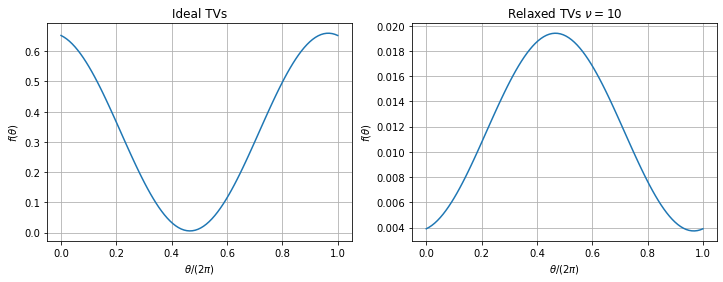

In [39]:
f, tmin = optimal_rotation_angle(xc_ideal)
f_relaxed, tmin_relaxed = optimal_rotation_angle(xc_relaxed)

t = np.linspace(0, 2 * np.pi, 100)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
ax.plot(t / (2 * np.pi), np.array([f(theta) for theta in t]))
ax.grid(True);
ax.set_xlabel(r"$\theta / (2 \pi)$")
ax.set_ylabel(r"$f(\theta)$");
ax.set_title("Ideal TVs")

ax = axs[1]
ax.plot(t / (2 * np.pi), np.array([f_relaxed(theta) for theta in t]))
ax.grid(True);
ax.set_xlabel(r"$\theta / (2 \pi)$")
ax.set_ylabel(r"$f(\theta)$");
ax.set_title(r"Relaxed TVs $\nu = {}$".format(num_sweeps));

In [40]:
norm(a.dot(x_ideal), axis=0) / norm(x_ideal, axis=0)

array([0.024, 0.024, 0.04 , 0.04 , 0.096, 0.096])

In [41]:
norm(a.dot(x_relaxed), axis=0) / norm(x_relaxed, axis=0)

array([0.326, 0.287, 0.281, 0.35 , 0.35 , 0.291])

In [42]:
x0 = hm.solve.run.random_test_matrix((n,), num_examples=num_examples)
norm(a.dot(x0), axis=0) / norm(x0, axis=0)

array([3.122, 3.185, 3.088, 3.14 , 2.83 , 2.74 ])

In [43]:
2.1 / 0.039

53.84615384615385

For the ideal TVs, I reproduced Karsten's result ($\theta = \frac{\pi}{6}$) and the alignment is perfect. For relaxed vectors there is almost no gain from alignment. Why?

Note: this is also the case if the $R$ used for *both* TV sets is based on relaxed vectors.

<!-- ## Effect on Neighbor Distances
We measure the $L_2$ differences between corresponding coarse variables in neighboring aggregates before and before and after alighment. -->

## Neighbor Pairs Alignment Angles
For each aggregate pair $(i,j=i+1)$, with test matrices $X$ and $Y$ of size $2 \times s$, respectively, where $s$ is the number of test vectors, define a separate optimal neighbor rotation angle $\theta_{i,j}$ that minimizes

$$ \theta_{i,j} = argmin_{\theta} f(\theta), f(\theta) := \frac12 \left\{ \|\cos(\theta) X_0 + \sin(\theta) X_1 - Y_0 \|_2^2 + \|-\sin(\theta) X_0 + \cos(\theta) X_1 - Y_1\|_2^2 \right\}. $$

Here $Z_j$ is the $j$th row of $Z$, $Z=X,Y, j=0,1$.

<!-- The differences are reduced by a factor of $1.3-3$. Not as dramatic as for ideal test vectors, but already significant. -->

In [44]:
def calculate_local_rotation_angles(n, aggregate_size, nc, xc):
    # Number of aggregates.
    N = n // aggregate_size
    num_coarse = nc * N
    p = 2

    phi = []
    for j, i in enumerate(range(0, num_coarse, nc)):
        f = lambda t: get_local_rotation_min_function(
            xc[i:i + nc], xc[np.arange(i + nc, i + 2*nc) % num_coarse], t, scale=False, p=p)
        result = optimize.minimize_scalar(f, bounds=(-np.pi, np.pi), method='brent')
        tmin = result.x % (2 * np.pi)
        #tmin = optimize.shgo(f, [(-np.pi, np.pi)], sampling_method='sobol').x[0]
        f0 = f(0)
        fmin = f(tmin)
        norm_before = norm(xc[i:i + nc] - xc[np.arange(i + nc, i + 2*nc) % num_coarse], axis=1) #** 2
        print("{:<2d} {:<+3f} {:2e} {:2e} ({:2f}) {}".format(i, tmin, f0, fmin, f0 / fmin, norm_before))
        phi.append(tmin)
    phi = np.array(phi)
    return phi

In [45]:
def plot_min_functions(n, aggregate_size, nc, xc):
    N = n // aggregate_size
    num_coarse = nc * N
    p = 2
    t = np.linspace(0, 2 * np.pi, 100)
    for j, i in enumerate(range(0, num_coarse, nc)):
        f = lambda t: get_local_rotation_min_function(
            xc[i:i + nc], xc[np.arange(i + nc, i + 2*nc) % num_coarse], t, scale=False, p=p)
        if j < 10:
            plt.plot(t, np.array([f(theta) for theta in t]), label="Agg {}".format(j))
    plt.grid(True);
    plt.legend();
#phi = get_local_rotation_angles(xc, n, aggregate_size, nc)

### Ideal Vectors
6 lowest eigenvectors.

0  +4.391682 6.239329e-01 9.233788e-02 (6.757063) [0.69  0.385]
2  +4.420418 6.021345e-01 8.632271e-02 (6.975389) [0.667 0.396]
4  +4.387997 6.262922e-01 9.262755e-02 (6.761403) [0.699 0.371]
6  +4.374811 6.311621e-01 9.000470e-02 (7.012546) [0.697 0.38 ]
8  +4.437793 5.949009e-01 8.833999e-02 (6.734220) [0.659 0.4  ]
10 +4.371161 6.335253e-01 9.026910e-02 (7.018186) [0.706 0.367]
12 +4.391680 6.239340e-01 9.233783e-02 (6.757080) [0.69  0.385]
14 +4.420444 6.021207e-01 8.632302e-02 (6.975204) [0.667 0.396]
16 +4.387955 6.263149e-01 9.262647e-02 (6.761727) [0.699 0.371]
18 +4.374858 6.311366e-01 9.000617e-02 (7.012148) [0.697 0.38 ]
20 +4.437752 5.949224e-01 8.833978e-02 (6.734480) [0.659 0.4  ]
22 +4.371183 6.335136e-01 9.026980e-02 (7.018001) [0.706 0.367]
24 +4.391682 6.239329e-01 9.233788e-02 (6.757063) [0.69  0.385]
26 +4.420418 6.021345e-01 8.632271e-02 (6.975389) [0.667 0.396]
28 +4.387997 6.262922e-01 9.262755e-02 (6.761403) [0.699 0.371]
30 +4.374811 6.311621e-01 9.000470e-02 (

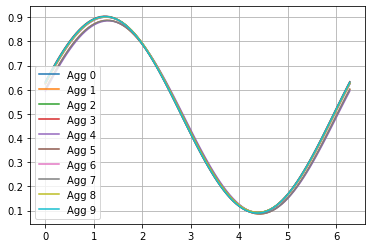

In [46]:
calculate_local_rotation_angles(n, aggregate_size, num_components, xc_ideal);
plot_min_functions(n, aggregate_size, num_components, xc_ideal);

### Relaxed Vectors

0  +1.152977 1.692134e-02 1.485157e-02 (1.139364) [0.101 0.082]
2  +3.780768 2.319513e-02 7.881997e-03 (2.942798) [0.12  0.094]
4  +4.029854 3.082950e-02 5.339463e-03 (5.773896) [0.136 0.111]
6  +4.700502 1.999237e-02 1.532769e-02 (1.304330) [0.087 0.111]
8  +4.174748 2.149806e-02 3.130805e-03 (6.866624) [0.118 0.087]
10 +3.978089 2.180332e-02 7.708413e-03 (2.828510) [0.131 0.068]
12 +5.931712 9.768281e-03 9.245107e-03 (1.056589) [0.069 0.071]
14 +4.724945 2.056119e-02 1.671187e-02 (1.230335) [0.102 0.101]
16 +5.350443 1.324946e-02 7.875867e-03 (1.682286) [0.096 0.063]
18 +5.459963 1.392199e-02 1.073317e-02 (1.297100) [0.103 0.058]
20 +5.494287 1.530318e-02 1.345377e-02 (1.137464) [0.108 0.061]
22 +5.508897 8.310199e-03 6.771055e-03 (1.227312) [0.08  0.044]
24 +3.718698 1.636499e-02 1.053957e-02 (1.552719) [0.104 0.075]
26 +3.858980 2.977086e-02 4.638667e-03 (6.417978) [0.14  0.101]
28 +4.625458 1.562477e-02 5.966989e-03 (2.618535) [0.094 0.082]
30 +3.971589 1.935698e-02 6.874199e-03 (

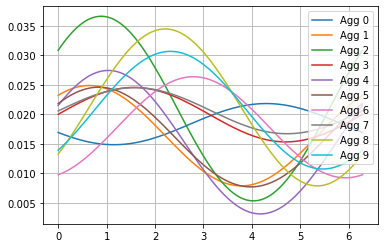

In [47]:
calculate_local_rotation_angles(n, aggregate_size, num_components, xc_relaxed);
plot_min_functions(n, aggregate_size, num_components, xc_relaxed);